# GT Analysis: Cross Validation to specify activity category identification variable
In this notebook, we analyze the activity category identification with different variable (cross validation).

#### adding required packages

In [9]:
import pandas as pd
from scipy.stats import gaussian_kde
import time
import numpy as np
import pickle
from joblib import Parallel, delayed
import datetime as dt
import random
import geopandas as gpd
from pyproj import Proj, itransform
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib

### specifying the saving location 


In [2]:
savingLoc = "Y:/ZahraEftekhar/phase4/"

In [32]:
#this class change coordinate system and map location coordinates to zones:
class LongLat:
    def __init__(self, *args):
        self.TAZ = 0
    def set_location(self, x, y):
        from shapely.geometry import Point
        self.location = Point(x, y)

    def changeCoordSys(self, initial: str = 'epsg:23031', final: str = 'epsg:28992'):
        from pyproj import Proj, transform
        from shapely.geometry import Point
        self.location = Point(transform(Proj(init=initial), Proj(init=final), self.location.x, self.location.y))

    def zoneMapping(self, onepolygon, polygonName):
        if (onepolygon.contains(self.location)):
            self.TAZ = polygonName
# this class only reads SHP:
class TAZmap:
    def __init__(self): pass

    def set_map(self, value):
        import geopandas as gpd
        self.map = gpd.read_file(value).loc[:,['mzr_id','geometry']]

#### importing probability of each activity category for each OD zone
This file is the output of R after applying a hierarchical model on location zones.

In [4]:
locProbability = pd.read_csv("{a}locProbability_0.1.csv".format(a=savingLoc))
# locProbability = pd.read_csv("{a}locProbability.csv".format(a=savingLoc))

zeroR = pd.Series(0, index=locProbability.columns)
locProbability = locProbability.append(zeroR,ignore_index=True)
locProbability.loc[locProbability["home"]==0,["home","work","other"]]=0.33
locProbability.set_index("mzr_id",inplace=True)
locProbability2 = locProbability
locProbability2 = locProbability2.drop('deviance',axis=1)
locProbability = np.log(locProbability)
locProbability.reset_index(drop=False, inplace=True)
locProbability.drop('deviance',axis=1,inplace=True)
locProbability

,mzr_id,home,work,other
0,5012,-1.108663,-1.108663,-1.108663
1,5013,-0.905137,-1.352044,-1.088258
2,5026,-0.327786,-2.897553,-1.494660
3,5038,-1.108663,-1.108663,-1.108663
4,5076,-1.108663,-1.108663,-1.108663
...,...,...,...,...
110,7822,-1.108663,-1.108663,-1.108663
111,7823,-1.108663,-1.108663,-1.108663
112,7831,-0.693150,-1.458888,-1.318609
113,7832,-0.529557,-1.687205,-1.486787


### Location Type Identification

Now, we can use the files from the previous step to reconstruct the travel diaries. This include to first indentify the event type i.e., `stay` or `pass-by`, then identify the acticity type , i.e., `home`, `work` or `other`. 

In [5]:
#we time the process
startTime = time.time()

seed=101
random.seed(seed)
# building the zero OD Matrix based on the number of zones in the SHP
map_mzr = TAZmap()
map_mzr.set_map("{a}amsterdamMezuroZones.shp".format(a=savingLoc))
inputs = map_mzr.map.geometry
map_mzr.map
acts = ['home','work','other']
allActivity = pd.DataFrame()
for act in acts:

    with open('{a}{aa}_seed{s}.pickle'.format(aa = act,a=savingLoc,s=seed),
              'rb') as handle:
        activityFile = pickle.load( handle)
    points = list(zip([float(num) for num in (activityFile.x.values)],[float(num) for num in (activityFile.y.values)]))

    # projection 1:
    p1 = Proj(init='epsg:23031')
    # projection 2: 
    p2 = Proj(init='epsg:28992')
    ptsX = []
    ptsY = []
    for pt in itransform(p1,p2,points, always_xy=True): 
        ptsX = ptsX + [pt[0]]
        ptsY = ptsY + [pt[1]]
    activityFile = gpd.GeoDataFrame(activityFile, geometry=gpd.points_from_xy(ptsX,ptsY))
    activityFile = activityFile.set_crs(epsg=28992)
    activityFile = gpd.sjoin(activityFile, map_mzr.map,how = "left")
    activityFile.mzr_id = (np.nan_to_num((activityFile.mzr_id)))
    activityFile.drop(['index_right'],axis=1,inplace=True)
    activityFile.rename(columns={'home': 'Thome','work':'Twork','other':'Tother','activity?':'Tactivity?'},inplace=True)
    activityFile = activityFile.merge(locProbability,on="mzr_id",how="left")
    activityFile["actualAct"] = act
    activityFile.rename(columns={'home': 'Shome','work':'Swork','other':'Sother'},inplace=True)
    activityFile['Sactivity?'] = activityFile[['Shome','Swork','Sother']].idxmax(axis = 1).str[1:]
    for stAct in acts:
        activityFile['ST{aaa}'.format(aaa=stAct)] = activityFile["T{aaa}".format(aaa=stAct)]+(activityFile["S{aaa}".format(aaa=stAct)])
    activityFile['STactivity?'] = activityFile[['SThome','STwork','STother']].idxmax(axis = 1).str[2:]
    allActivity = allActivity.append(activityFile,ignore_index = True)
    
with open("{a}crossVal_activity_seed{b}".format(a=savingLoc,b=seed), 'wb') as handle:
    pickle.dump(activityFile, handle, protocol=pickle.HIGHEST_PROTOCOL)
print((time.time() - startTime)//60,'minutes')


c:\Users\zahraeftekhar\.conda\envs\ODmatrices\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\zahraeftekhar\.conda\envs\ODmatrices\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\ZAHRAE~1\AppData\Local\Temp/ipykernel_2484/3276335403.py:26: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#u

0.0 minutes


In [6]:
allActivity

,VEHICLE,activityType,x,y,start,end,duration,Thome,Twork,Tother,...,mzr_id,Shome,Swork,Sother,actualAct,Sactivity?,SThome,STwork,STother,STactivity?
0,1,home,632315.3322837545,5817000.086435355,17:10:47,1 days 06:29:59,0 days 13:19:12,-21.726681,-29.144357,-176.325143,...,5329.0,-0.515987,-1.819222,-1.423221,home,home,-22.242668,-30.963579,-177.748365,home
1,10,home,632315.3322837545,5817000.086435355,15:54:40,1 days 05:35:01,0 days 13:40:21,-21.903882,-28.394947,-191.224230,...,5329.0,-0.515987,-1.819222,-1.423221,home,home,-22.419869,-30.214169,-192.647451,home
2,100007,home,628436.430959822,5803393.987399707,16:17:37,1 days 06:16:14,0 days 13:58:37,-21.813981,-28.845450,-204.495522,...,7510.0,-1.399418,-0.986287,-0.966795,home,other,-23.213399,-29.831737,-205.462316,home
3,100009,home,629437.8503055726,5802862.885345862,16:51:09,1 days 07:16:12,0 days 14:25:03,-21.759391,-30.233505,-224.586650,...,7510.0,-1.399418,-0.986287,-0.966795,home,other,-23.158809,-31.219793,-225.553445,home
4,10001,home,625308.5056096063,5792622.8888017945,17:00:03,1 days 06:57:56,0 days 13:57:53,-21.724203,-29.677638,-203.866641,...,7831.0,-0.693150,-1.458888,-1.318609,home,home,-22.417353,-31.136526,-205.185250,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59048,99981,business,638653.6948047496,5796600.87829093,11:01:36,11:58:18,0 days 00:56:42,-24.392313,-27.630539,-21.462321,...,5013.0,-0.905137,-1.352044,-1.088258,other,home,-25.297450,-28.982583,-22.550580,other
59049,99981,service,628678.4437764077,5804360.208169168,13:45:12,14:05:42,0 days 00:20:30,-23.829944,-28.609311,-21.633565,...,7510.0,-1.399418,-0.986287,-0.966795,other,other,-25.229362,-29.595599,-22.600359,other
59050,99981,sozializing,625919.0063776571,5797745.121597694,17:38:42,18:33:40,0 days 00:54:58,-22.930915,-31.099611,-20.834820,...,7832.0,-0.529557,-1.687205,-1.486787,other,home,-23.460473,-32.786816,-22.321607,other
59051,99981,sozializing,630615.3221452166,5799270.946322026,18:43:47,20:21:10,0 days 01:37:23,-23.074317,-36.053440,-21.014100,...,6119.0,-1.271283,-1.478916,-0.710002,other,other,-24.345600,-37.532355,-21.724102,other


## plot the trip distance distribution:

In [94]:
def eucl_distances(df): # df is a dataframe containing 'x' and 'y' as columns
    from pyproj import Proj, transform
    from shapely.geometry import Point
    tripDistances = []
    df.x = pd.to_numeric(df.x)
    df.y = pd.to_numeric(df.y)
    for i in np.arange(0,len(df)):
        if i+1<len(df):
            x1, y1 = Point(transform(Proj(init='epsg:23031'), Proj(init='epsg:28992'), df.loc[i,'x'], df.loc[i,'y'])).coords.xy
            x2, y2 = Point(transform(Proj(init='epsg:23031'), Proj(init='epsg:28992'), df.loc[i+1,'x'], df.loc[i+1,'y'])).coords.xy
            x1 = x1.tolist()[0]
            x2 = x2.tolist()[0]
            y1 = y1.tolist()[0]
            y2 = y2.tolist()[0]
            tripDistances+=[((x2 - x1)**2+ (y1 - y2)**2)**0.5]
    return tripDistances


In [95]:
from pyproj import Proj, transform
from shapely.geometry import Point
VEHICLEdict = allActivity.sort_values(['VEHICLE', 'start']).groupby(['VEHICLE'])
VEHICLES = list(VEHICLEdict.groups.keys())
tripDistances = []
for VEHICLE in VEHICLES[0:100]:
    test = pd.DataFrame(VEHICLEdict.get_group(VEHICLE))[['x', 'y']].reset_index(drop=True)
    tripDistances += eucl_distances(test)

c:\Users\zahraeftekhar\.conda\envs\ODmatrices\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\zahraeftekhar\.conda\envs\ODmatrices\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\ZAHRAE~1\AppData\Local\Temp/ipykernel_2484/1206528979.py:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#up

([<matplotlib.axis.YTick at 0x2475ac38ca0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

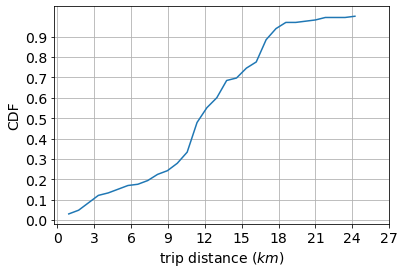

In [136]:
data = [x/1000 for x in tripDistances]
# getting data of the histogram
count, bins_count = np.histogram(data, bins=30)
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
# plotting PDF and CDF
# plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.rcParams['font.size'] = 14

plt.plot(bins_count[1:], cdf)
plt.grid()
plt.xlabel('trip distance ($km$)')
plt.ylabel('CDF')
plt.xticks(np.arange(0,30,3))
plt.yticks(np.arange(0,1, 0.1))

# plt.legend()
# # fixed bin size
# # bins = np.arange(0, 25000, 1000)
# plt.hist(tripDistances, bins= bins)
# # len(VEHICLES)

## Plot the TAZ size distribution:

([<matplotlib.axis.YTick at 0x2475abd9880>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

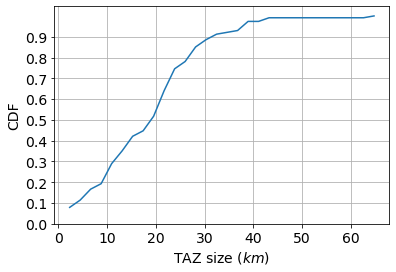

In [135]:
map_mzr = TAZmap()
map_mzr.set_map("{a}amsterdamMezuroZones.shp".format(a=savingLoc))
inputs = map_mzr.map.geometry
data = gpd.GeoSeries(inputs).length/1000
# plt.hist(data, bins = 30)
# getting data of the histogram
count, bins_count = np.histogram(data, bins=30)
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
# plotting PDF and CDF
# plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.rcParams['font.size'] = 14

plt.plot(bins_count[1:], cdf)
plt.grid()
plt.xlabel('TAZ size ($km$)')
plt.ylabel('CDF')
plt.xticks(np.arange(0,70,10))
plt.yticks(np.arange(0,1, 0.1))

# plt.legend()


In [124]:
inputs.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [86]:
tripDistances
print(x1,y1,'\n',x2,y2)

119415.3025819266 482454.31470492797 
 125114.65075764644 499812.30059174274


In [87]:
tripDistances
# y2

[18269.708363160637]

In [7]:
y_st = allActivity["STactivity?"].values
y_s = allActivity["Sactivity?"].values
y_t = allActivity["Tactivity?"].values
y_actu = allActivity["actualAct"].values

conST = pd.DataFrame(confusion_matrix(y_actu, y_st,labels=["home", "work", "other"]).T,
                     index = ["predicted home","predicted work","predicted other"],columns = ["observed home","observed work","observed other"])
print("ST:\n",conST)

conT = pd.DataFrame(confusion_matrix(y_actu, y_t,labels=["home", "work", "other"]).T,
                    index = ["predicted home","predicted work","predicted other"],columns = ["observed home","observed work","observed other"])
print("T:\n",conT)

conS = pd.DataFrame(confusion_matrix(y_actu, y_s,labels=["home", "work", "other"]).T,
                    index = ["predicted home","predicted work","predicted other"],columns = ["observed home","observed work","observed other"])
print("S:\n",conS)

with pd.ExcelWriter('{a}activityConfusion.xlsx'.format(a=savingLoc)) as writer:  
    conST.to_excel(writer, sheet_name='ST')
    conT.to_excel(writer, sheet_name='T')
    conS.to_excel(writer, sheet_name='S')


ST:
                  observed home  observed work  observed other
predicted home           22659            111             568
predicted work             223          12899             217
predicted other           4516            678           17182
T:
                  observed home  observed work  observed other
predicted home           22458             52             175
predicted work             289          12963             248
predicted other           4651            673           17544
S:
                  observed home  observed work  observed other
predicted home           25434          10952           15242
predicted work             488            585             447
predicted other           1476           2151            2278


In [8]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
for y_predicted in  [y_st, y_s, y_t]:
    print('Balanced accuracy score: ', balanced_accuracy_score(y_actu, y_predicted ))
    print('precision macro score: ', precision_score(y_actu, y_predicted , average='macro'))
    print('precision micro score: ', precision_score(y_actu, y_predicted , average='micro'))
    print('recall score: ', recall_score(y_actu, y_predicted , average = 'weighted'))

Balanced accuracy score:  0.9085660761700359
precision macro score:  0.901932044636534
precision micro score:  0.8930960323776946
recall score:  0.8930960323776946
Balanced accuracy score:  0.36594736683608997
precision macro score:  0.4210942803668813
precision micro score:  0.47917971991262087
recall score:  0.47917971991262087
Balanced accuracy score:  0.914395201359708
precision macro score:  0.9058003989231982
precision micro score:  0.8969061690345961
recall score:  0.8969061690345961


home false-negative error based on start of the activity 
start of the activity other 


<Figure size 864x576 with 0 Axes>

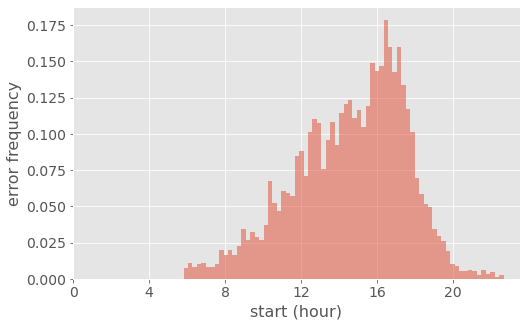

<Figure size 864x576 with 0 Axes>

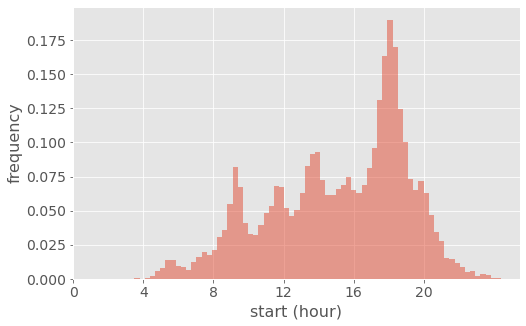

In [480]:
# __________________ HOME PredictionError_start______________
kk =  allActivity[(allActivity["STactivity?"]!=allActivity["actualAct"]) & (allActivity.loc[:,"actualAct"]=="home")]
homeFalseNeg_start = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"start"]]
homeFalseNeg_start = pd.DataFrame(pd.to_numeric(homeFalseNeg_start)/3600)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# plt.figure()
plt.style.use('ggplot')
ax1 = (homeFalseNeg_start).plot(kind='hist', bins=72, density=True, alpha=0.5, label='prediction error of home activity', legend=False)
ax1.set_xlabel(u'start (hour)',fontsize=16)
print('home false-negative error based on start of the activity ')
ax1.set_ylabel('error frequency',fontsize=16)
plt.xticks((np.arange(0, 24, step=4)),fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.savefig("{a}homeFNs_start.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}homeFNs_start.png".format(a=savingLoc),dpi = 150)

# __________________ other_start______________
kk =  allActivity[(allActivity.loc[:,"actualAct"]=="other")]
other_start = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"start"]]
other_start = pd.DataFrame(pd.to_numeric(other_start)/3600)
# (other_start)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# # plt.figure()
plt.style.use('ggplot')
ax1 = (other_start).plot(kind='hist', bins=72, density=True, alpha=0.5, label='actual start of other activity', legend=False)
ax1.set_xlabel(u'start (hour)',fontsize=16)
print('start of the activity other ')
ax1.set_ylabel('frequency',fontsize=16)
plt.xticks((np.arange(0, 24, step=4)),fontsize=14)
plt.yticks(fontsize=14)

# plt.show()
plt.savefig("{a}otherActual_start.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}otherActual_start.png".format(a=savingLoc),dpi = 150)



home false-negative error based on duration of the activity 
duration of the activity other 


<Figure size 864x576 with 0 Axes>

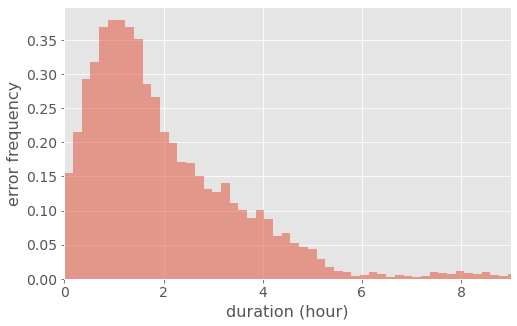

<Figure size 864x576 with 0 Axes>

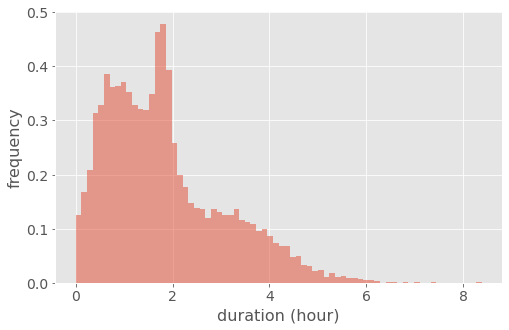

In [481]:
# __________________ HOME PredictionError_duration______________
kk =  allActivity[(allActivity["STactivity?"]!=allActivity["actualAct"]) & (allActivity.loc[:,"actualAct"]=="home")]
homeFalseNeg_duration = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"duration"]]
homeFalseNeg_duration = pd.DataFrame(pd.to_numeric(homeFalseNeg_duration)/3600)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# plt.figure()
plt.style.use('ggplot')
ax1 = (homeFalseNeg_duration).plot(kind='hist', bins=72, density=True, alpha=0.5, label='prediction error of home activity', legend=False)
ax1.set_xlabel(u'duration (hour)',fontsize=16)
print('home false-negative error based on duration of the activity ')
ax1.set_ylabel('error frequency',fontsize=16)
plt.xticks((np.arange(0, 10, step=2)),fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((0,9))
# plt.show()
plt.savefig("{a}homeFNs_duration.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}homeFNs_duration.png".format(a=savingLoc),dpi = 150)

# __________________ other_duration______________
kk =  allActivity[(allActivity.loc[:,"actualAct"]=="other")]
other_duration = [pd.to_timedelta(i).total_seconds() for i in kk.loc[:,"duration"]]
other_duration = pd.DataFrame(pd.to_numeric(other_duration)/3600)
# (other_duration)
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.figure(figsize=(12, 8))
params = {'figure.figsize': (8, 5)}
plt.rcParams.update(params)

# # plt.figure()
plt.style.use('ggplot')
ax1 = (other_duration).plot(kind='hist', bins=72, density=True, alpha=0.5, label='actual duration of other activity', legend=False)
ax1.set_xlabel(u'duration (hour)',fontsize=16)
print('duration of the activity other ')
ax1.set_ylabel('frequency',fontsize=16)
plt.xticks((np.arange(0, 10, step=2)),fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.savefig("{a}otherActual_duration.pdf".format(a=savingLoc),dpi = 150)
plt.savefig("{a}otherActual_duration.png".format(a=savingLoc),dpi = 150)

In [474]:
print("overall accuracy when using only spatial variable: ",round(sum(allActivity["Sactivity?"]==allActivity['actualAct'])/len(allActivity)*10000)/100,"%")
print("overall accuracy when using only temporal variables: ",round(sum(allActivity["Tactivity?"]==allActivity['actualAct'])/len(allActivity)*10000)/100,"%")
print("overall accuracy when using both temporal and spatial variables: ",round(sum(allActivity["STactivity?"]==allActivity['actualAct'])/len(allActivity)*10000)/100,"%")


overall accuracy when using only spatial variable:  47.92 %
overall accuracy when using only temporal variables:  89.69 %
overall accuracy when using both temporal and spatial variables:  89.31 %


The following cell produces the table needed to plot `Average probability of each activity category based only on location OD zone` in arcGIS:

In [34]:
locProbability2
map_mzr = TAZmap()
map_mzr.set_map("{a}amsterdamMezuroZones.shp".format(a=savingLoc))
inputs = map_mzr.map.geometry
from geopandas.tools import sjoin
locProbability2 = gpd.GeoDataFrame(locProbability2)
# locProbability2.drop('deviance',axis=1,inplace=True)
join_left_df = locProbability2.merge(map_mzr.map,on="mzr_id", how="left")
# join_left_df.drop('deviance',axis=1,inplace=True)
# join_left_df.to_file("{a}locProbability.shp".format(a=savingLoc))
print(len(join_left_df))
join_left_df2 = join_left_df.loc[join_left_df.loc[:,"home"]!=0.33,:]
join_left_df2.to_file("{a}locProbability.shp".format(a=savingLoc))
len(join_left_df2)

115


32